In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import cPickle as pickle

In [2]:
cd ..

/Users/odatakuma/cmu/FleetAI


In [3]:
import json
from engine.mapper.osmloader import OsmLoader

osm_path = 'analytics/data/osm/osm_nyc.json'
osm = OsmLoader(osm_path)

# of nodes: 5092898
# of highways: 57803


In [4]:
%%time
G = osm.get_graph(road_max_length=150, seg_max_length=150)
print len(G.nodes()), len(G.edges())

105553 219351
CPU times: user 2min 32s, sys: 22.6 s, total: 2min 55s
Wall time: 3min 8s


In [5]:
path = 'engine/data/nyc_network_graph.pkl'
with open(path, 'wb') as f:
    pickle.dump(G, f)

In [6]:
path = 'engine/data/nyc_network_graph.pkl'
with open(path, 'r') as f:
    G = pickle.load(f)

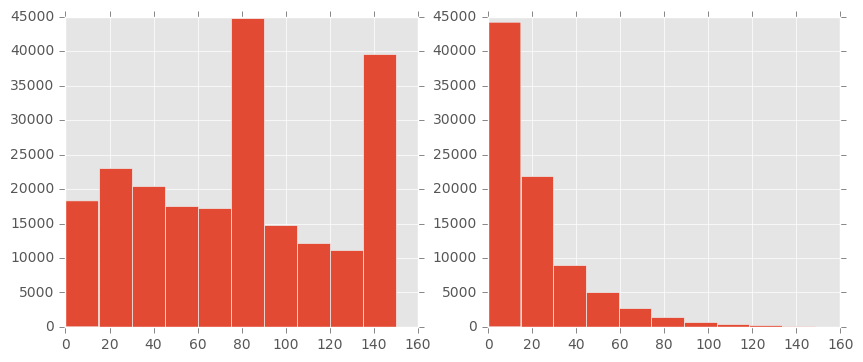

In [7]:
lengths = [l for _, _, l in G.edges_iter(data='length')]
seg_lengths = [a-b for _, _, d in G.edges_iter(data=True) 
               if d.get('seg_length') and len(d['seg_length']) > 1
               for a, b in zip(d['seg_length'][1:], d['seg_length'][:-1])]

plt.style.use('ggplot')
plt.figure(figsize=[10, 4])
plt.subplot(121)
plt.hist(lengths)
plt.subplot(122)
plt.hist(seg_lengths);

## Compute road/intxn density

In [15]:
G = osm.get_graph(drive=False, road_max_length=100000, seg_max_length=10)
print len(G.nodes()), len(G.edges())

70632 105444


In [16]:
lengths = [d['length'] for _, _, d in G.edges_iter(data=True) if d.get('seg_length')]
sum(lengths)

10234374.548110962

In [17]:
nsegs = [len(d['seg_length']) for _, _, d in G.edges_iter(data=True) if d.get('seg_length')]
sum(lengths)/sum(nsegs)

9.2050228661083917

In [18]:
from engine.mapper import geohelper as gh

road_locs = [zip(d['lat'], d['lon']) for _, _, d in G.edges_iter(data=True) if d.get('lat')]
road_density = gh.road_density(road_locs)

In [19]:
node_locs =[(d['lat'], d['lon']) for _, d in G.nodes_iter(data=True) if d.get('lat')]
intxn_density = gh.intxn_density(node_locs)

In [20]:
zones = pd.read_csv("analytics/data/geohash.csv")
zones.head()

,geohash,total_pickup,total_dropoff,lat,lon,taxi_zone,road_density,intxn_density,motorway_density,motorxn_density
0,dr5qgxx,0,8,40.603409,-74.015579,10,38,35,18,1
1,dr5qgxy,0,8,40.604782,-74.016953,10,39,8,4,0
2,dr5qgxz,0,9,40.604782,-74.015579,10,22,0,0,0
3,dr5qgz7,1,19,40.602036,-74.010086,10,28,9,0,0
4,dr5qgz8,2,11,40.603409,-74.014206,10,59,14,0,0


In [21]:
zones['road_density'] = [road_density[g] for g in zones.geohash]
zones['intxn_density'] = [intxn_density[g] for g in zones.geohash]
zones.head()

,geohash,total_pickup,total_dropoff,lat,lon,taxi_zone,road_density,intxn_density,motorway_density,motorxn_density
0,dr5qgxx,0,8,40.603409,-74.015579,10,38,35,18,1
1,dr5qgxy,0,8,40.604782,-74.016953,10,39,8,4,0
2,dr5qgxz,0,9,40.604782,-74.015579,10,22,0,0,0
3,dr5qgz7,1,19,40.602036,-74.010086,10,28,9,0,0
4,dr5qgz8,2,11,40.603409,-74.014206,10,59,14,0,0


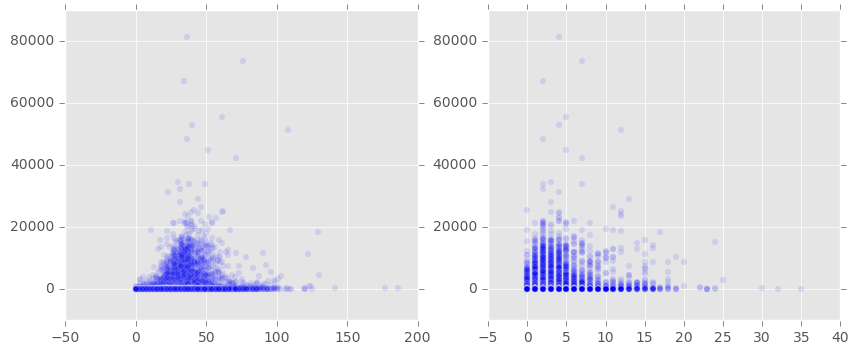

In [25]:
plt.figure(figsize=[10, 4])
plt.subplot(121)
plt.scatter(zones.road_density, zones.total_pickup, alpha=0.1)
plt.subplot(122)
plt.scatter(zones.intxn_density, zones.total_pickup, alpha=0.1);

## Recompute road/intxn density including motorways

In [26]:
G = osm.get_graph(drive=True, road_max_length=100000, seg_max_length=10)
road_locs = [zip(d['lat'], d['lon']) for _, _, d in G.edges_iter(data=True) if d.get('lat')]
road_density = gh.road_density(road_locs)
node_locs =[(d['lat'], d['lon']) for _, d in G.nodes_iter(data=True) if d.get('lat')]
intxn_density = gh.intxn_density(node_locs)

In [28]:
zones['motorway_density'] = [road_density[g] for g in zones.geohash]
zones['motorxn_density'] = [intxn_density[g] for g in zones.geohash]
zones.head()

,geohash,total_pickup,total_dropoff,lat,lon,taxi_zone,road_density,intxn_density,motorway_density,motorxn_density
0,dr5qgxx,0,8,40.603409,-74.015579,10,38,35,56,36
1,dr5qgxy,0,8,40.604782,-74.016953,10,39,8,43,8
2,dr5qgxz,0,9,40.604782,-74.015579,10,22,0,22,0
3,dr5qgz7,1,19,40.602036,-74.010086,10,28,9,28,9
4,dr5qgz8,2,11,40.603409,-74.014206,10,59,14,59,14


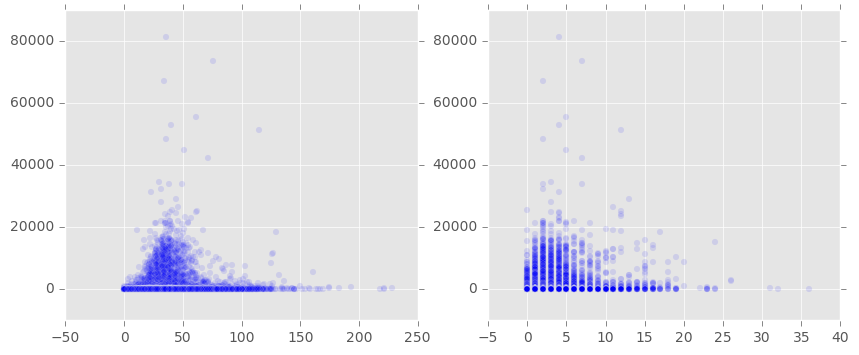

In [29]:
plt.figure(figsize=[10, 4])
plt.subplot(121)
plt.scatter(zones.motorway_density, zones.total_pickup, alpha=0.1)
plt.subplot(122)
plt.scatter(zones.motorxn_density, zones.total_pickup, alpha=0.1);

In [30]:
zones['motorxn_density'] -= zones.intxn_density
zones['motorway_density'] -= zones.road_density

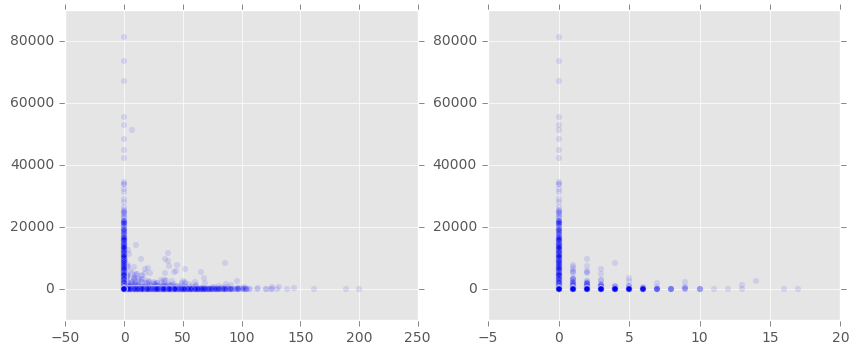

In [31]:
plt.figure(figsize=[10, 4])
plt.subplot(121)
plt.scatter(zones.motorway_density, zones.total_pickup, alpha=0.1)
plt.subplot(122)
plt.scatter(zones.motorxn_density, zones.total_pickup, alpha=0.1);

In [32]:
zones.to_csv("analytics/data/geohash.csv", index=False)

## Test Path Generator

In [8]:
df = pd.read_csv('analytics/data/taxi_trips/taxi_tripdata_2016-05.csv', nrows=1000)
df.head()

,request_id,date,dayofweek,dropoff_latitude,dropoff_longitude,hour,minute,pickup_latitude,pickup_longitude,second,trip_distance,trip_time,great_circle_distance,pickup_geohash,dropoff_geohash,pickup_zone,dropoff_zone
0,0,1,6,40.730099,-73.983986,0,0,40.768040,-73.985901,0,3.60,17.516667,4221,dr5rz4r,dr5rz2t,172,55
1,1,1,6,40.744633,-73.980995,0,0,40.741573,-73.993073,0,1.09,7.016667,1072,dr5rsg5,dr5rtk7,255,79
2,2,1,6,40.733002,-74.002258,0,0,40.684601,-73.991943,0,4.21,19.783333,5451,dr72j1h,dr5rtjs,74,111
3,3,1,6,40.765469,-73.975700,0,0,40.744751,-73.991577,0,1.68,7.516667,2663,dr5rz63,dr5rw3c,172,197
4,4,1,6,40.737564,-73.997498,0,0,40.740192,-74.005280,0,0.56,6.650000,717,dr5rtj6,dr5rsg7,254,255


In [9]:
from engine.mapper.pathgenerator import PathGenerator

path_generator = PathGenerator(G)

In [10]:
i = 11
origin = df[['pickup_latitude', 'pickup_longitude']].values[i]
destination = df[['dropoff_latitude', 'dropoff_longitude']].values[i]
trip_time = df['trip_time'].values[i]
path = path_generator.get_path(origin, destination, trip_time)

In [11]:
from engine.mapper.geohelper import visualize_trajectory
visualize_trajectory(
    center_lat_lon=origin,
    blue_lat_lon=path,
    blue_radius=[5]*len(path),
    marker_locs=[origin, destination,]
)

file created!


In [12]:
%%time
for i in range(100):
    origin = df[['pickup_latitude', 'pickup_longitude']].values[i]
    destination = df[['dropoff_latitude', 'dropoff_longitude']].values[i]
    trip_time = df['trip_time'].values[i]
    path = path_generator.get_path(origin, destination, trip_time)

CPU times: user 3.85 s, sys: 270 ms, total: 4.12 s
Wall time: 4.74 s


In [ ]:
# # Unit Test for map_match method

# for i, (u, v, d) in enumerate(G.edges_iter(data=True)):
#     if 'lat' not in d: continue
#     for j, loc in enumerate(zip(d['lat'], d['lon'])):
#         u1, v1, d1 = path_generator.map_match(loc)
#         if u1==u and v1==v:
#             if np.abs((d['seg_length']+[d['length']])[j] - d1) > 1:
#                 print (d['seg_length']+[d['length']])[j], d1
#     if i > 1000: break

# for i, (u, v, d) in enumerate(G.edges_iter(data=True)):
#     if 'lat' not in d: continue
#     for j, loc in enumerate(zip(d['lat'], d['lon'])):
#         mloc = path_generator.mm_convert(loc)
#         dlt = gh.distance_in_meters(loc[0], loc[1], mloc[0], mloc[1])
#         if dlt > 1:
#             print u, v, dlt
#     if i > 1000: break

# df = pd.read_csv(data_path,
#                  usecols=[
#                      'pickup_latitude',
#                      'pickup_longitude',
#                      'dropoff_latitude',
#                      'dropoff_longitude',
#                      'trip_time'
#                  ], nrows=1000)


# d = []
# for i, loc in enumerate(df[['pickup_latitude', 'pickup_longitude']].values):
#     try:
#         mloc = path_generator.mm_convert(loc)
#     except:
#         continue
#     d.append(gh.distance_in_meters(loc[0], loc[1], mloc[0], mloc[1]))
# plt.hist(d);